# Gene annotation

In [3]:
from __future__ import annotations

from pathlib import Path
from typing import Iterable, Union

import matplotlib.pyplot as plt
import matplotlib_venn as venn
import numpy as np
import pandas as pd
import pkg_resources
from moped import Compound, Model, Monomer, Reaction

print(pkg_resources.get_distribution("moped").version)


1.10.0


In [4]:
def get_all_db_links(els: Iterable[Union[Monomer, Reaction, Compound]]) -> dict[str, set[str]]:
    db_links = {}
    for monomer in els:
        for db, links in monomer.database_links.items():
            db_links.setdefault(db, set()).update(links)
    return db_links


def contains_match(db_links: dict[str, set[str]], el: Union[Monomer, Reaction, Compound]) -> bool:
    for db, links in el.database_links.items():
        for link in links:
            if link in db_links.get(db, set()):
                return True
    return False


def num_matching_monomers(m1: Model, m2: Model) -> int:
    db_links = get_all_db_links(m2.monomers.values())
    matches = 0
    for monomer in m1.monomers.values():
        if contains_match(db_links, monomer):
            matches += 1
    return matches

def num_matching_reactions(m1: Model, m2: Model) -> int:
    db_links = get_all_db_links(m2.reactions.values())
    matches = 0
    for rxn in m1.reactions.values():
        if contains_match(db_links, rxn):
            matches += 1
    return matches

def num_matching_compounds(m1: Model, m2: Model) -> int:
    db_links = get_all_db_links(m2.compounds.values())
    matches = 0
    for cpd in m1.compounds.values():
        if contains_match(db_links, cpd):
            matches += 1
    return matches

In [5]:
ecoli_moped = Model()
ecoli_moped.read_from_sbml(str(Path("../generated/models/ecoli.xml")))
ecoli_moped

Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled


Model: Model
    compounds: 2197
    reactions: 2795

In [6]:
ecoli_ref = Model()
ecoli_ref.read_from_sbml(str(Path("../data/models/iML1515.xml")))
ecoli_ref

Model: Model
    compounds: 1877
    reactions: 2712

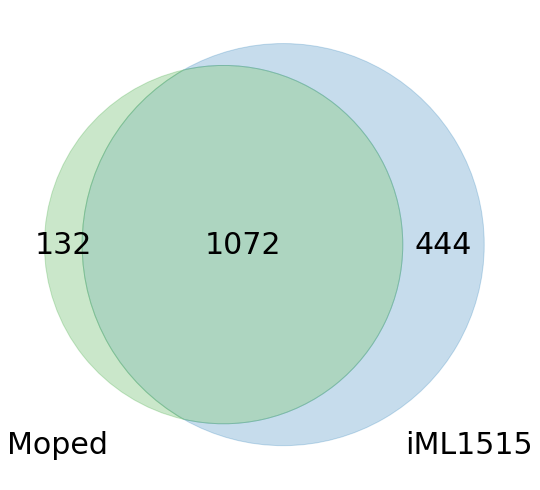

In [11]:
matches = num_matching_monomers(ecoli_moped, ecoli_ref)
non_left = len(ecoli_moped.monomers) - matches
non_right = len(ecoli_ref.monomers) - matches

fig, ax = plt.subplots(figsize=(8, 8))
# fig.suptitle("Matching genes", fontsize=20)

v = venn.venn2({"10": non_left, "01": non_right, "11": matches}, set_labels=("Moped", "iML1515"), ax=ax)
v.get_label_by_id("A").set_position((-0.4, -0.5))  # type: ignore
v.get_label_by_id("B").set_position((0.4, -0.5))  # type: ignore
v.get_label_by_id("A").set_fontsize(30)  # type: ignore
v.get_label_by_id("B").set_fontsize(30)  # type: ignore
v.get_label_by_id("10").set_fontsize(30)
v.get_label_by_id("11").set_fontsize(30)
v.get_label_by_id("01").set_fontsize(30)

l = v.get_patch_by_id("10")
r = v.get_patch_by_id("01")
m = v.get_patch_by_id("11")


l.set_alpha(0.25)
l.set_color("C2")

m.set_alpha(0.5)
m.set_color("#5CAC82")

r.set_alpha(0.25)
r.set_color("C0")

fig.tight_layout()
plt.savefig("../figures/gene_annotation_venn.pdf")